In [5]:
%load_ext autoreload
%autoreload 2
# type: ignore
from nanopyx.data.examples.download import ExampleDataManager
from nanopyx.core.transform.binning import rebin2d
from nanopyx.core.transform.image_magnify import fourier_zoom, catmull_rom_zoom, lanczos_zoom
from scipy.ndimage import zoom as scipy_zoom
from skimage.transform import (
    rescale as ski_rescale, 
    resize as ski_resize, 
    downscale_local_mean as ski_downscale_local_mean
    )
from cv2 import resize as cv_resize
from cv2 import INTER_LANCZOS4

M = 2
downloader = ExampleDataManager()
z = downloader.get_zarr("SMLMS2013_HDTubulinAlexa647")
image = z['data'][0]
imageDownsampled = rebin2d(image, M, mode="mean")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/var/folders/5h/k40_2g894bb4fv5q510s2mq80000gn/T/nanopix_data/SMLMS2013_HDTubulinAlexa647/dataset.zarr


In [6]:
%%prun -s cumulative -q -l 100 -T prun_magnify.profile
# Profile the run

imageFFTZoom = fourier_zoom(imageDownsampled, M)
imageCRZoom = catmull_rom_zoom(imageDownsampled, M)
imageScipyZoom = scipy_zoom(imageDownsampled, M)
imageSkiZoom = ski_rescale(imageDownsampled, M, anti_aliasing=False)
imageCVZoom = cv_resize(imageDownsampled, None, fx=M, fy=M, interpolation = INTER_LANCZOS4)
imageLZoom = lanczos_zoom(imageDownsampled, M, taps = 2)

 
*** Profile printout saved to text file 'prun_magnify.profile'.


In [7]:
# Show profiling
print(open('prun_magnify.profile', 'r').read())

         486 function calls (462 primitive calls) in 0.013 seconds

   Ordered by: cumulative time
   List reduced from 177 to 100 due to restriction <100>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.013    0.013 {built-in method builtins.exec}
        1    0.000    0.000    0.013    0.013 <string>:1(<module>)
        1    0.000    0.000    0.007    0.007 image_magnify.py:74(lanczos_zoom)
        1    0.000    0.000    0.007    0.007 {nanopyx.core.transform.interpolation.lanczos.magnify}
        1    0.000    0.000    0.007    0.007 lanczos.pyx:9(magnify)
        1    0.007    0.007    0.007    0.007 lanczos.pyx:26(_magnify)
        2    0.000    0.000    0.003    0.002 _interpolation.py:691(zoom)
        2    0.003    0.001    0.003    0.001 {built-in method scipy.ndimage._nd_image.zoom_shift}
        1    0.000    0.000    0.001    0.001 utils.py:388(fixed_func)
        1    0.000    0.000    0.001    0.001 utils.py:314(fi

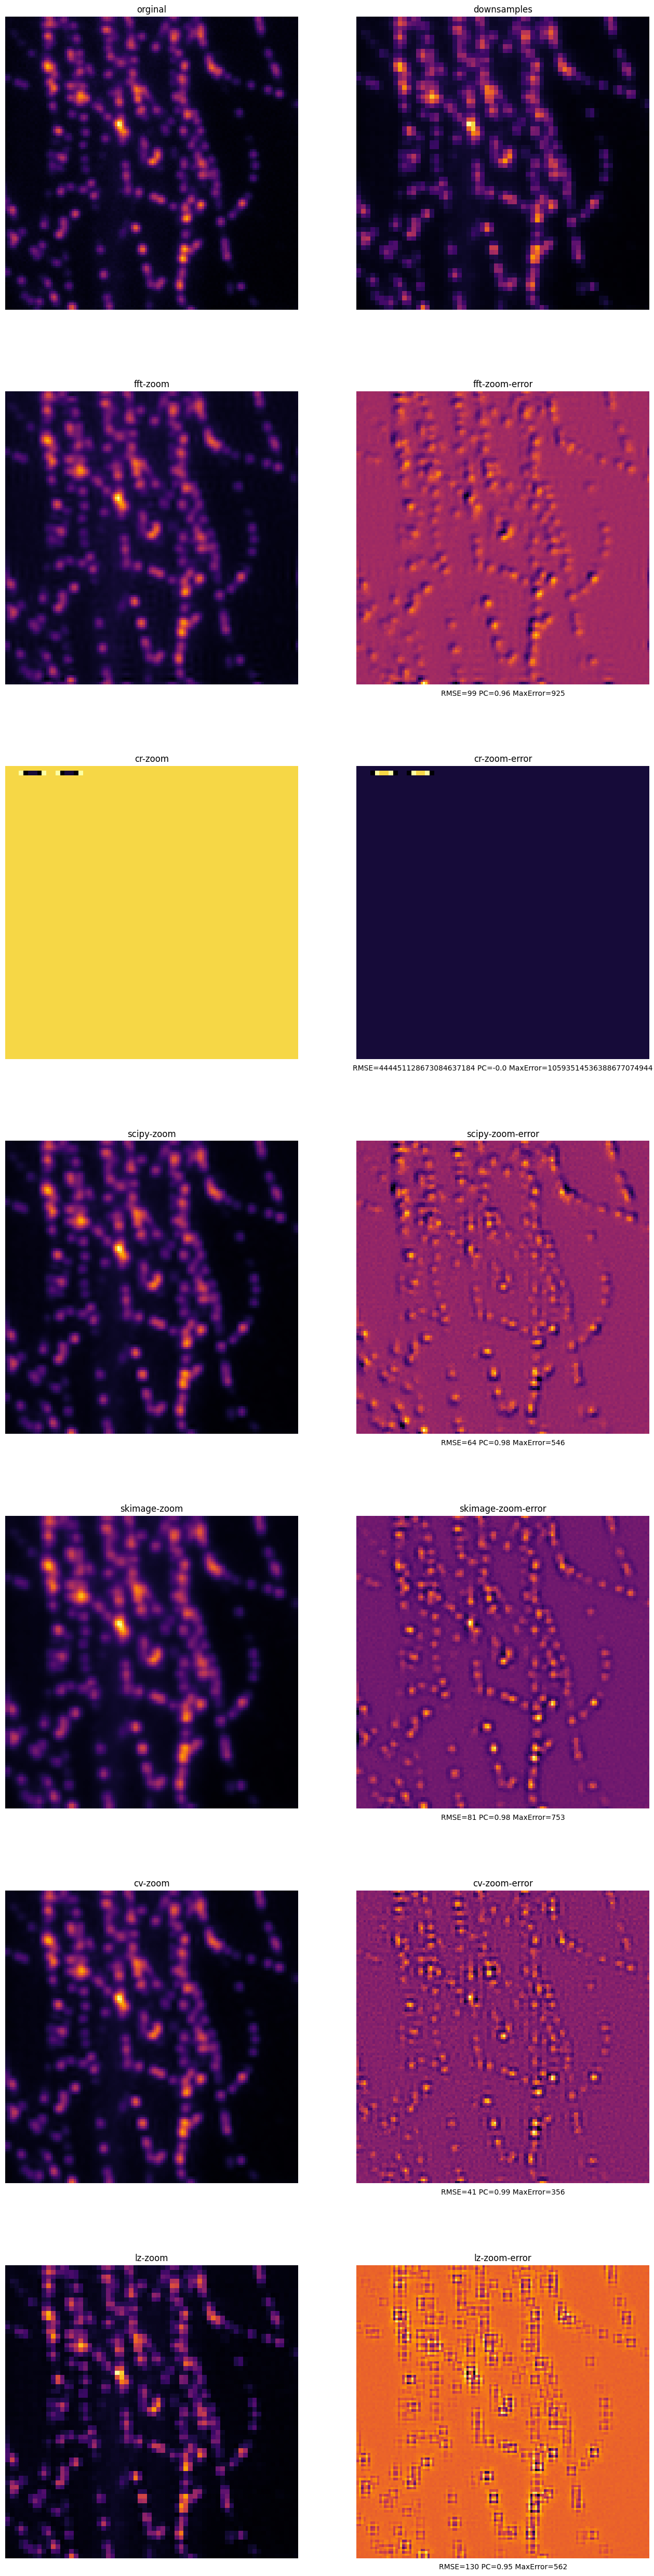

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from nanopyx.core.analysis.pearson_correlation import pearson_correlation
import numpy as np

# Create a figure with 3 subplots arranged in a row
fig, axs = plt.subplots(7, 2, figsize=(16, 4*16))
sns.heatmap(image, ax=axs[0,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(imageDownsampled, ax=axs[0,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[0,0].set_title("orginal")
axs[0,1].set_title("downsamples")

error = image-imageFFTZoom
rmse = round((error**2).mean()**0.5)
pc = pearson_correlation(image, imageFFTZoom)
sns.heatmap(imageFFTZoom, ax=axs[1,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(error, ax=axs[1,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[1,0].set_title("fft-zoom")
axs[1,1].set_title("fft-zoom-error")
axs[1,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

error = image-imageCRZoom
rmse = round((error**2).mean()**0.5)
pc = pearson_correlation(image, imageCRZoom)
sns.heatmap(imageCRZoom, ax=axs[2,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(error, ax=axs[2,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[2,0].set_title("cr-zoom")
axs[2,1].set_title("cr-zoom-error")
axs[2,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

error = image-imageScipyZoom
rmse = round((error**2).mean()**0.5)
pc = pearson_correlation(image, imageScipyZoom)
sns.heatmap(imageScipyZoom, ax=axs[3,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(error, ax=axs[3,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[3,0].set_title("scipy-zoom")
axs[3,1].set_title("scipy-zoom-error")
axs[3,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

error = image-imageSkiZoom
rmse = round((error**2).mean()**0.5)
pc = pearson_correlation(image, imageSkiZoom)
sns.heatmap(imageSkiZoom, ax=axs[4,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(error, ax=axs[4,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[4,0].set_title("skimage-zoom")
axs[4,1].set_title("skimage-zoom-error")
axs[4,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

error = image-imageCVZoom
rmse = round((error**2).mean()**0.5)
pc = pearson_correlation(image, imageCVZoom)
sns.heatmap(imageCVZoom, ax=axs[5,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(error, ax=axs[5,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[5,0].set_title("cv-zoom")
axs[5,1].set_title("cv-zoom-error")
axs[5,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

error = image-imageLZoom
rmse = round((error**2).mean()**0.5)
pc = pearson_correlation(image, imageLZoom)
sns.heatmap(imageLZoom, ax=axs[6,0], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
sns.heatmap(error, ax=axs[6,1], cmap='inferno', cbar=False, square=True, xticklabels=False, yticklabels=False)
axs[6,0].set_title("lz-zoom")
axs[6,1].set_title("lz-zoom-error")
axs[6,1].set_xlabel(f"RMSE={rmse} PC={round(pc, 2)} MaxError={round(np.max(error))}")

# Show the figure
plt.show()
